In [34]:
import json
import os

with open('dataset.json', 'r') as f:
    dataset = json.load(f)

In [44]:
threshold = 10
points = []
for string, data in dataset['strings'].items():
    if len(data['malware_files']) > threshold:
        points.append((len(data['malware_files']), len(data['benign_files'])))

print(f"The number of strings that appear in more than {threshold} malware files is: {len(points)}")
print(f"The number of strings overall is: {len(dataset['strings'])}")

The number of strings that appear in more than 10 malware files is: 3973
The number of strings overall is: 1395616


In [43]:
# print some strings in a lot of malware files (>100) but not in benign files
for string, data in dataset['strings'].items():
    if len(data['malware_files']) > 100 and len(data['benign_files']) == 0:
        print(string)

333333333333333333
` MB
}#jPh
cXXY
\XZ]
2VUR
\XXZ]^
\XZ]^
VURP
TVUR
Z]^\
\Z]^
QTUSO
X[]\Y
QTUS
[]\Y
XWWb
]\YWW[
OQTU
]\YW[
QTU1
]\Y[
\YW[
aVVW
ZVX[
0TSP
ZVVX[\
ZVX[\
TSPN
RTSP
X[\Z
ZX[\
ORSQ
Y[ZW
[ZWY
VUU`
ORS/
[ZWUUY
MORS
[ZWUY
ZWUY
=4l?:
{h2)
888d
;888dRRR


The points on the line y=0 are interesting.
Those are strings that are in a lot of malware files but not in any benign files.


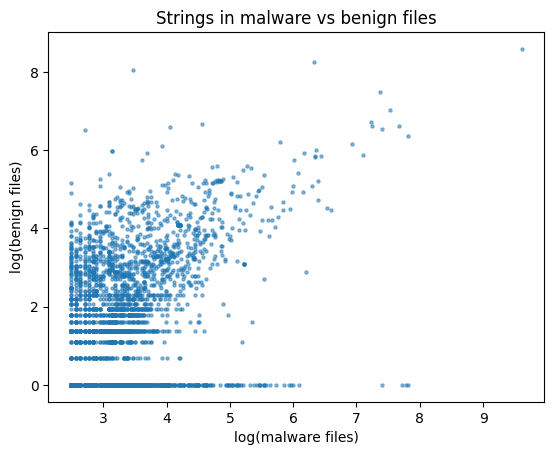

In [37]:
import matplotlib.pyplot as plt
import math
# points is a list of tuples (x, y)
x = [math.log(p[0]+1) for p in points]
y = [math.log(p[1]+1) for p in points]


plt.xlabel('log(malware files)')
plt.ylabel('log(benign files)')
plt.title('Strings in malware vs benign files')
plt.scatter(x, y, alpha=0.5, s=5)
plt.show()


The points on the line y=0 are interesting. \
Those are strings that are in a lot of malware files but not in any benign files.

In [42]:
from data.DataString import DataString

# now lets test the categories of the strings that are in a lot of malware files
categories = {
    'number': 0,
    'IP': 0,
    'URL': 0,
    'URI': 0,
    'DLL': 0,
    'DLL_function': 0,
    'Text': 0,
    'random': 0
}

malwares_threshold = 10
benign_threshold = 3
for string, data in dataset['strings'].items():
    if len(data['malware_files']) >= malwares_threshold and \
        len(data['benign_files']) <= benign_threshold:
        categories[DataString.category(string)] += 1

for category, count in categories.items():
    print(f'{category}: {count}')

number: 34
IP: 0
URL: 0
URI: 16
DLL: 15
DLL_function: 200
Text: 898
random: 1479


As expected, there are a lot of Text's and DLL_function's that are in a lot of malware files but not in any benign files. \
There are also some DLL's that are suspicious. \
An important observation that there are a LOT of "random" strings, some of them could be misclassified strings, some might be unique sequence of characters that are used in a lot of malwares. This is something that can be useful for the classification.

In [74]:
# now lets create new dataset with only the strings that are in a lot of malware files and not in benign files
import copy

malwares_threshold = 10
benign_threshold = 3

new_dataset = copy.deepcopy(dataset)

for string, data in dataset['strings'].items():
    if len(data['malware_files']) < malwares_threshold or \
        len(data['benign_files']) > benign_threshold:
        del new_dataset['strings'][string]
        
print(f"Number of strings in original dataset: {len(dataset['strings'])}")
print(f"Number of strings in new dataset: {len(new_dataset['strings'])}")

Number of strings in original dataset: 1395609
Number of strings in new dataset: 2642


In [75]:
# for each string in the new dataset save the score of: malware_frequency / (benign_frequency + 1)
scanned_files = new_dataset['scanned_files']
malware_files_num = len(list(filter(lambda x: 'malware' in x, scanned_files)))
benign_files_num = len(list(filter(lambda x: 'benign' in x, scanned_files)))

for string, data in new_dataset['strings'].items():
    new_data = {}
    new_data['suspicious_score'] = data['suspicious_score']
    malware_frequency = len(data['malware_files']) / malware_files_num
    benign_frequency = len(data['benign_files']) / benign_files_num
    new_data['frequency_score'] = malware_frequency / (benign_frequency + 1) * max(malware_files_num, benign_files_num)
    new_dataset['strings'][string] = new_data

In [77]:
# save the new dataset
with open(f'strings_above{malwares_threshold}_below{benign_threshold}.json', 'w') as f:
    json.dump(new_dataset, f, indent=4)